# Sales Demand Time Series Forecasting, end-to-end ML pipeline
### TO DO: In addition to XGBoost, experiment model training with ARIMA, Prophet, LSTM Modeling  

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px

import xgboost as xgb 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

In [2]:
# Read in Data 
train = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    parse_dates=['date']
)
# Filter down to highest grossing store number 44 and largest category Grocery I to simplify the dataset 
temp = train.loc[(train['store_nbr']==44) & (train['family']=='GROCERY I'),['date','sales']].reset_index()
#temp = pd.get_dummies(train,columns=['family','store_nbr'],drop_first=True).drop(['id'],axis=1)
# Plot 
px.line(temp,x='date',y='sales')

In [6]:
# Feature Engineering - Add temporal columns 
#temp = temp.drop('index',axis=1)

temp['dayofweek'] = temp['date'].dt.dayofweek
temp['quarter'] = temp['date'].dt.quarter
temp['month'] = temp['date'].dt.month
temp['year'] = temp['date'].dt.year
temp['dayofyear'] = temp['date'].dt.dayofyear
temp['dayofmonth'] = temp['date'].dt.day
temp['weekofyear'] = temp['date'].dt.isocalendar().week

#View 
temp

,date,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2013-01-01,0.0,1,1,1,2013,1,1,1
1,2013-01-02,10686.0,2,1,1,2013,2,2,1
2,2013-01-03,7342.0,3,1,1,2013,3,3,1
3,2013-01-04,7250.0,4,1,1,2013,4,4,1
4,2013-01-05,10699.0,5,1,1,2013,5,5,1
...,...,...,...,...,...,...,...,...,...
1679,2017-08-11,9979.0,4,3,8,2017,223,11,32
1680,2017-08-12,9391.0,5,3,8,2017,224,12,32
1681,2017-08-13,9811.0,6,3,8,2017,225,13,32
1682,2017-08-14,8318.0,0,3,8,2017,226,14,33


In [7]:
# Split Data 
X = temp.drop(['sales'],axis=1)
y = temp['sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False)

X_train_date = X_train['date']
X_train = X_train.drop(['date'],axis=1)
X_test_date = X_test['date']
X_test = X_test.drop(['date'],axis=1)

2025/01/06 19:46:02 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


2025/01/06 19:46:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/06 19:46:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/01/06 19:46:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/nikiagrawal/Desktop/Python_Dev/.pdf_env/lib/python3.11/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.

RMSLE score: 0.54511
RMSE: 2580.2581553084497
R2 Score: 0.4695790256864063


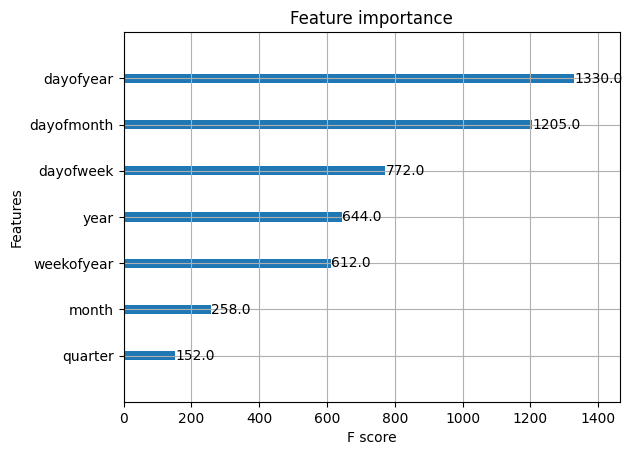

<Run: data=<RunData: metrics={}, params={'alpha': '0.1',
 'colsample_bytree': '0.8',
 'custom_metric': 'None',
 'early_stopping_rounds': 'None',
 'eta': '0.1',
 'eval_metric': 'rmsle',
 'lambda': '1',
 'max_depth': '6',
 'maximize': 'None',
 'num_boost_round': '100',
 'objective': 'reg:squarederror',
 'subsample': '0.8',
 'verbose_eval': 'True'}, tags={'mlflow.log-model.history': '[{"run_id": "7ff62b1e1a3f4b7a90badd5fcfc11051", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2025-01-07 00:46:02.607497", "model_uuid": '
                             '"64cfb524e1b348549fed720a84cddfd0", "flavors": '
                             '{"python_function": {"loader_module": '
                             '"mlflow.xgboost", "python_version": "3.11.11", '
                             '"data": "model.xgb", "env": {"conda": '
                             '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                             '"xg

In [9]:
# Input as a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost Model Paramaters 
params = {
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eval_metric': 'rmsle',            # Root Mean Squared Error as evaluation metric
    'max_depth': 6,                   # Maximum depth of the trees
    'eta': 0.1,                       # Learning rate
    'subsample': 0.8,                 # Fraction of samples used for each tree
    'colsample_bytree': 0.8,          # Fraction of features used for each tree
    'alpha': 0.1,                     # L2 regularization term on weights
    'lambda': 1,                      # L1 regularization term
}

#ML FLOW Experimentation tracking, logging models to save to Model Registry 
import mlflow
mlflow.autolog()
with mlflow.start_run():


    # Training 
    num_round = 100  # Number of boosting rounds (iterations)
    bst = xgb.train(params, dtrain, num_round)

    # Prediction
    y_pred = bst.predict(dtest)

    # Evaluation 
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred))

print("RMSLE score: %.5f" % RMSLE )
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Feature Importances 
import matplotlib.pyplot as plt
xgb.plot_importance(bst)
plt.show()

# Visualize the automatically logged run results to validate what we recorded
mlflow.last_active_run()

In [10]:
!mlflow ui --port 8080 #Go to http://localhost:8080/ 

[2025-01-06 19:46:11 -0500] [46348] [INFO] Starting gunicorn 23.0.0
[2025-01-06 19:46:11 -0500] [46348] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2025-01-06 19:46:11 -0500] [46348] [ERROR] connection to ('127.0.0.1', 8080) failed: [Errno 48] Address already in use
[2025-01-06 19:46:12 -0500] [46348] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2025-01-06 19:46:12 -0500] [46348] [ERROR] connection to ('127.0.0.1', 8080) failed: [Errno 48] Address already in use
[2025-01-06 19:46:13 -0500] [46348] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2025-01-06 19:46:13 -0500] [46348] [ERROR] connection to ('127.0.0.1', 8080) failed: [Errno 48] Address already in use
[2025-01-06 19:46:14 -0500] [46348] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2025-01-06 19:46:14 -0500] [46348] [ERROR] connection to ('127.0.0.1', 8080) failed: [Errno 48] Address already in use
[2025-01-06 19:46:15 -0500] [46348] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2025-01-06 19:46:15 -0500] [46348] [

# View ML Flow Experiment Tracking, Model Registry 
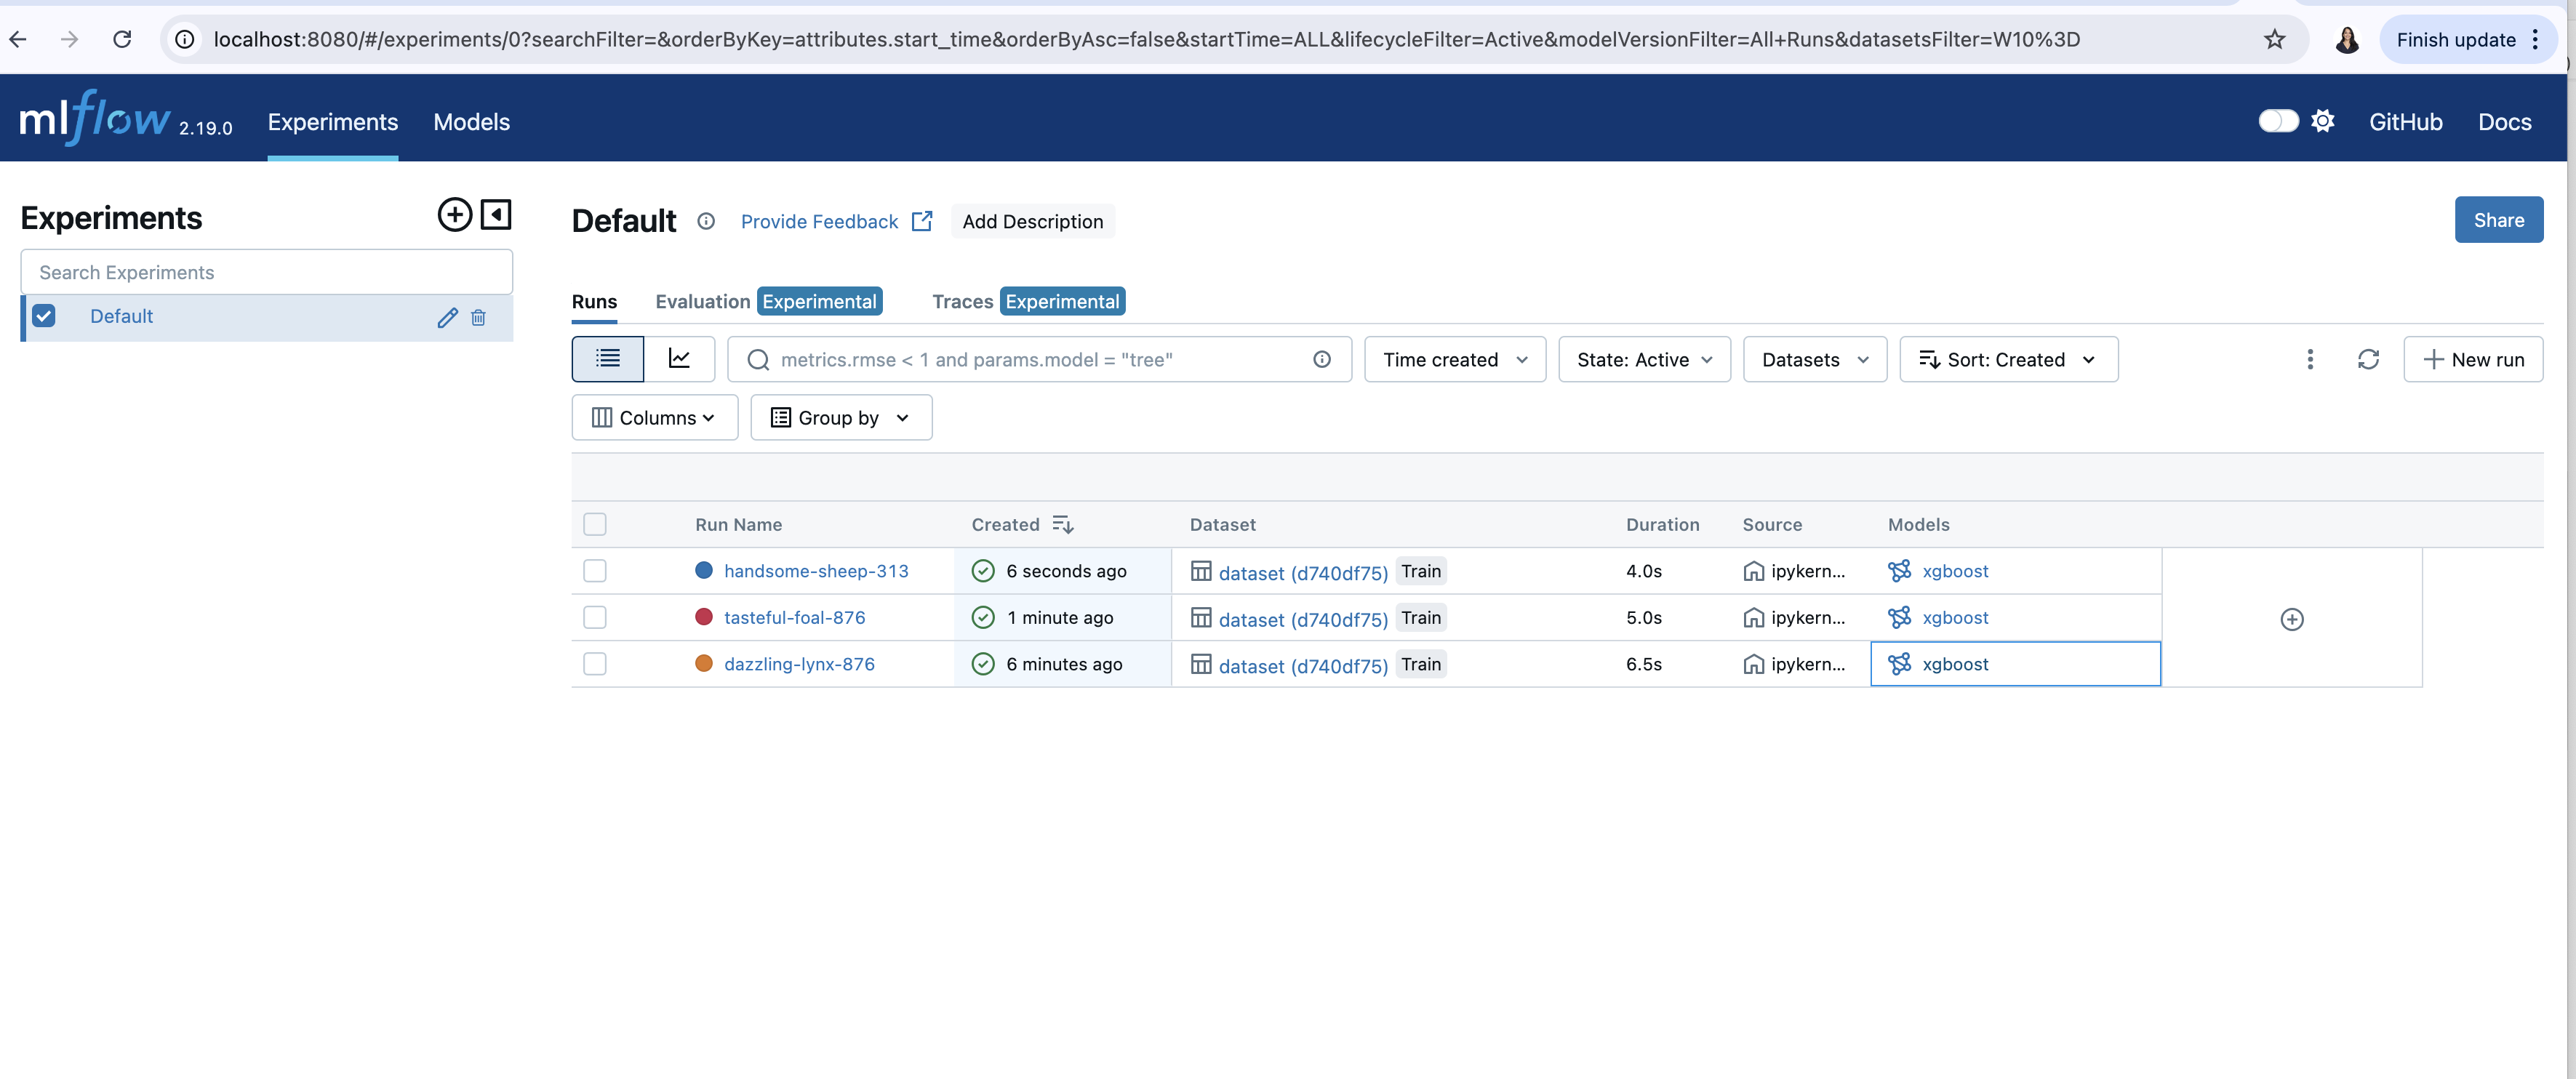

<Axes: xlabel='Date'>

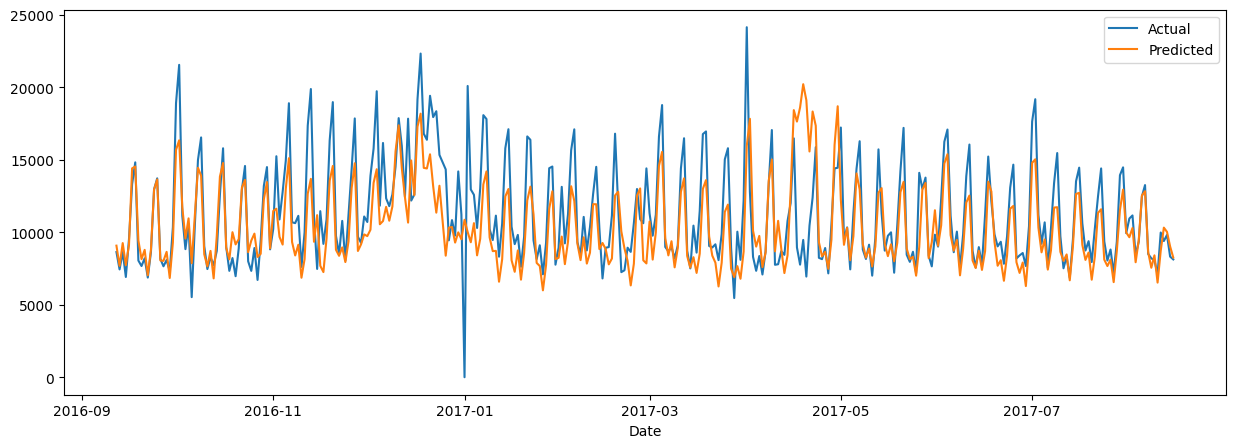

In [11]:
# Organize Results 
results = pd.DataFrame()
results['Date'] = X_test_date.dt.date.values
results['Actual'] = pd.Series(y_test.values)
results['Predicted'] = pd.Series(y_pred)

# Plot actual and forecasted store sales 
results.plot(x='Date',y=['Actual','Predicted'],figsize=(15,5))

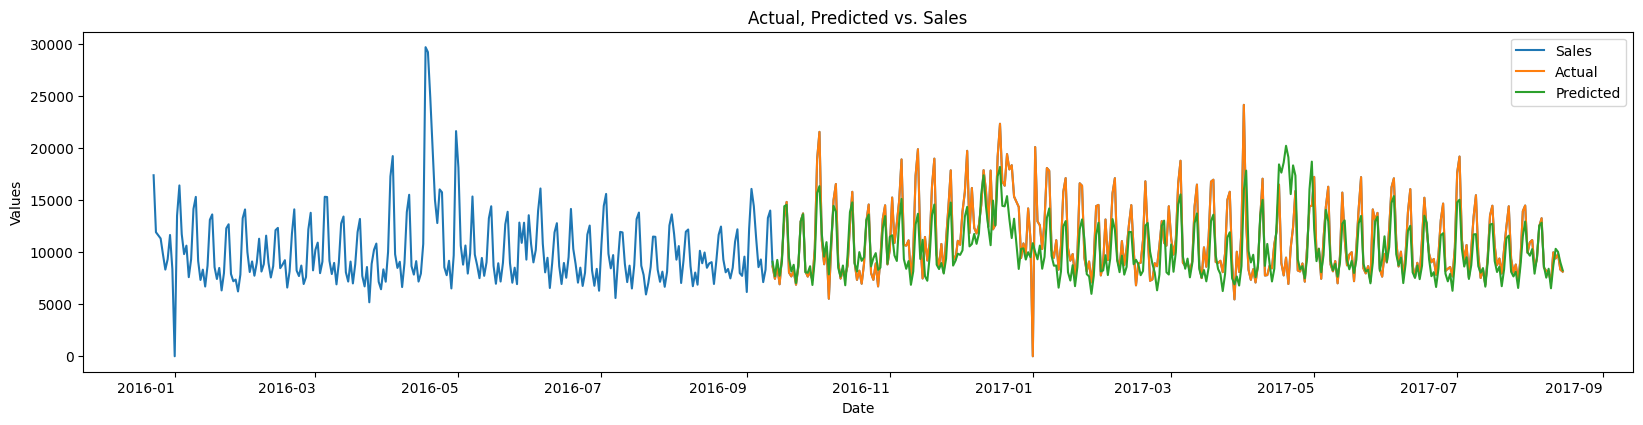

In [12]:

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(20, 5))

# Plot the 'sales' column from the 'temp' DataFrame
temp[['date', 'sales']][-600:].plot(x='date', y='sales', ax=ax, label='Sales')

# Plot the 'Actual' and 'Predicted' columns from the 'results' DataFrame
results.plot(x='Date', y=['Actual', 'Predicted'], ax=ax)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('Actual, Predicted vs. Sales')

# Display the legend
ax.legend()

# Show the plot
plt.show()

<Axes: xlabel='Date'>

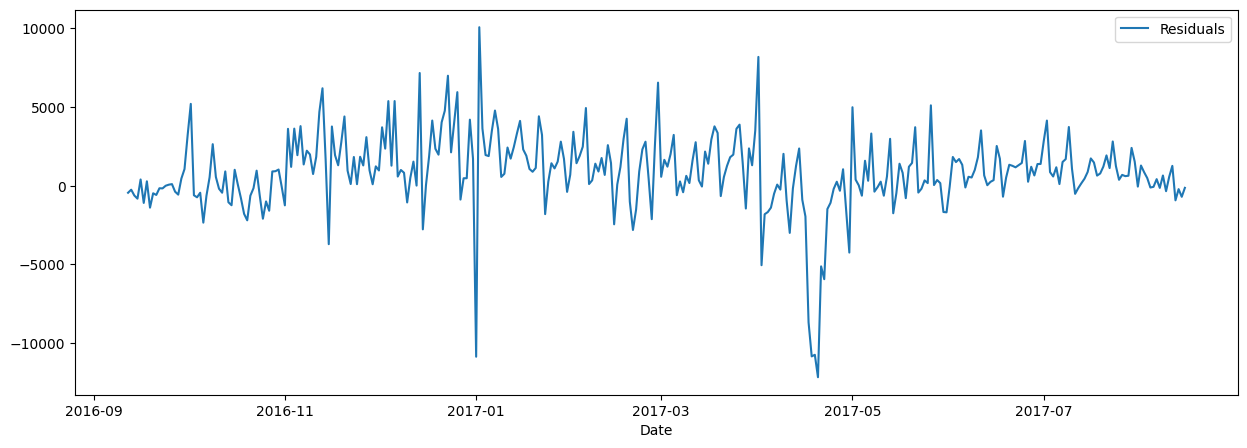

In [13]:
results['Residuals'] =  results['Actual']-results['Predicted']
results.plot(x='Date',y='Residuals',figsize=(15,5))

In [59]:
#Feast Feature Store: follow this tutorial: https://github.com/feast-dev/feast/blob/master/examples/quickstart/quickstart.ipynb